# Hyperparameters Tunning for Deep Learning Models (full of errors)
TODO add description

In [1]:
import optuna 
import sys; sys.path.append('..')
from thesis_package import utils, aimodels as myai, metrics

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error
num_trials = 50

c:\Users\jamil\Documents\IST\Thesis\new_thesis\code\AI-to-forecast-constraints-in-the-energy-systems\env\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Max u

## MLP: Classification Dataset

Build optuna study...

[I 2022-09-21 14:04:56,772] A new study created in memory with name: no-name-fadc5bcc-6e40-4466-a527-7117ea57ee92
[I 2022-09-21 14:08:52,790] Trial 0 finished with value: 0.14595362044486512 and parameters: {'hidden_size': 70, 'n_layers': 2, 'dropout': 0.4745333417453604, 'activation': 'relu', 'optimizer': 'adam', 'lr': 0.0025824836717157195, 'epochs': 52, 'batch_size': 1}. Best is trial 0 with value: 0.14595362044486512.
[I 2022-09-21 14:09:49,319] Trial 1 finished with value: 0.12415675369483495 and parameters: {'hidden_size': 51, 'n_layers': 1, 'dropout': 0.3790033517079505, 'activation': 'sigmoid', 'optimizer': 'sgd', 'lr': 0.02904370384908276, 'epochs': 19, 'batch_size': 128}. Best is trial 0 with value: 0.14595362044486512.
[I 2022-09-21 14:11:22,834] Trial 2 finished with value: 0.12348674464933337 and parameters: {'hidden_size': 10, 'n_layers': 3, 'dropout': 0.08627635360414093, 'activation': 'relu', 'optimizer': 'sgd', 'lr': 0.008751366006310116, 'epochs': 34, 'batch_size': 64

Number of finished trials:  50
Best trial:
  Value: 0.16464042860086545
  Params: 
    hidden_size: 69
    n_layers: 1
    dropout: 0.22628939853329905
    activation: tanh
    optimizer: adam
    lr: 0.0026741772486018607
    epochs: 93
    batch_size: 2


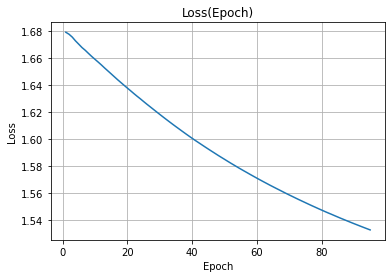

In [2]:
# Build optuna objective function.
import optuna
import sklearn 

def objective(trial):
    # Data loading
    y_max_u_bool = pd.read_csv('..\data\ground_truth\\res_bus_vm_pu_max_bool_constr.csv').drop(columns='timestamps')
    y_max_u = y_max_u_bool[utils.cols_with_positive_values(y_max_u_bool)]
    exogenous_data = pd.read_csv('..\data\processed\production\exogenous_data_extended.csv').drop(columns=['date'])
    X_max_u_bool_train, X_max_u_bool_test, y_max_u_bool_train, y_max_u_bool_test, scaler = utils.split_and_suffle(exogenous_data, y_max_u_bool, test_size=0.2, scaling=True)
    data = {'X_train':X_max_u_bool_train.astype(float),
            'X_test': X_max_u_bool_test.astype(float),
            'y_train':y_max_u_bool_train.astype(float),
            'y_test': y_max_u_bool_test.astype(float)
        }
    # Dataset object creation
    _dataset = myai.ThesisDataset(data)
    hyper_params = {
        'input_size': _dataset.X.shape[1],
        'hidden_size': trial.suggest_int('hidden_size', 1, 100),
        'output_size': _dataset.y.shape[1],
        'n_layers': trial.suggest_int('n_layers', 1, 3),
        'dropout': trial.suggest_float('dropout', 0.0, 0.5),
        'activation': trial.suggest_categorical('activation', ['relu', 'tanh', 'sigmoid']),
        'optimizer': trial.suggest_categorical('optimizer', ['adam', 'sgd']),
        'lr': trial.suggest_float('lr', 1e-5, 1e-1, log=True),
        'epochs': trial.suggest_int('epochs', 1, 100),
        'batch_size': trial.suggest_categorical('batch_size', [1, 2, 4, 8, 16, 32, 64, 128, 256, 512, 1024]),
        'classifier': True
        }
    model = myai.Context(myai.MultilayerPerceptronStrategy(hyper_params))
    model.fit(data)
    prediction = model.predict(data).detach().numpy().round().astype(bool)
    prediction = pd.DataFrame(prediction, columns=y_max_u_bool.columns)
    f1_score = sklearn.metrics.f1_score(data['y_test'], prediction, average='micro')
    return f1_score
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=num_trials)
print("Number of finished trials: ", len(study.trials))
print("Best trial:")
trial = study.best_trial
print("  Value: {}".format(trial.value))
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))
# Write the results to a csv file.
with open("./hyper_params_results/params_mlp_classifier_max_u.csv", "w") as f:
    f.write("params,value\n")
    for key, value in trial.params.items():
        f.write("{},{}\n".format(key, value))
    f.write("classifier,True\n")
    f.write("value,{}\n".format(trial.value))

## MLP: Regression Sparse Dataset

[I 2022-09-21 16:33:18,355] A new study created in memory with name: no-name-add24866-55b8-46be-845e-040d6a1c3c9e
[I 2022-09-21 16:34:44,684] Trial 0 finished with value: -0.3680618939231846 and parameters: {'hidden_size': 4, 'n_layers': 3, 'dropout': 0.0498242390940663, 'activation': 'relu', 'optimizer': 'sgd', 'lr': 0.002038656840453264, 'epochs': 51, 'batch_size': 1024}. Best is trial 0 with value: -0.3680618939231846.
[I 2022-09-21 16:35:27,387] Trial 1 finished with value: 0.004577272337348974 and parameters: {'hidden_size': 58, 'n_layers': 1, 'dropout': 0.23693431261033404, 'activation': 'sigmoid', 'optimizer': 'adam', 'lr': 0.007401181254142201, 'epochs': 18, 'batch_size': 1024}. Best is trial 1 with value: 0.004577272337348974.
[I 2022-09-21 16:38:20,289] Trial 2 finished with value: -0.06969504842118658 and parameters: {'hidden_size': 46, 'n_layers': 1, 'dropout': 0.13917703734958642, 'activation': 'tanh', 'optimizer': 'adam', 'lr': 2.3205460745780083e-05, 'epochs': 92, 'batch

Number of finished trials:  50
Best trial:
  Value: 1.5483470399373407
  Params: 
    hidden_size: 19
    n_layers: 3
    dropout: 0.4415292238988939
    activation: relu
    optimizer: sgd
    lr: 0.003549282320247246
    epochs: 30
    batch_size: 16


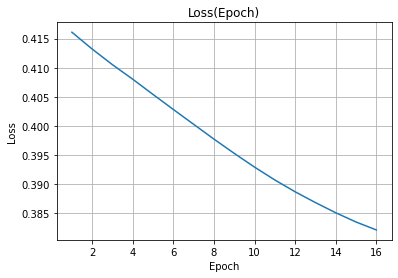

In [3]:
# Build optuna objective function.
import optuna
import sklearn 

def objective(trial):
    # Data loading
    y_max_u = pd.read_csv('..\data\ground_truth\\res_bus_vm_pu_max_constr.csv').drop(columns='timestamps')
    y_max_u = y_max_u[utils.cols_with_positive_values(y_max_u)]
    exogenous_data = pd.read_csv('..\data\processed\production\exogenous_data_extended.csv').drop(columns=['date'])
    X_max_u_train, X_max_u_test, y_max_u_train, y_max_u_test, scaler = utils.split_and_suffle(exogenous_data, y_max_u, test_size=0.2, scaling=True)
    data = {'X_train':X_max_u_train.astype(float),
            'X_test': X_max_u_test.astype(float),
            'y_train':y_max_u_train.astype(float),
            'y_test': y_max_u_test.astype(float)
        }
    # Dataset object creation
    _dataset = myai.ThesisDataset(data)
    hyper_params = {
        'input_size': _dataset.X.shape[1],
        'hidden_size': trial.suggest_int('hidden_size', 1, 100),
        'output_size': _dataset.y.shape[1],
        'n_layers': trial.suggest_int('n_layers', 1, 3),
        'dropout': trial.suggest_float('dropout', 0.0, 0.5),
        'activation': trial.suggest_categorical('activation', ['relu', 'tanh', 'sigmoid']),
        'optimizer': trial.suggest_categorical('optimizer', ['adam', 'sgd']),
        'lr': trial.suggest_float('lr', 1e-5, 1e-1, log=True),
        'epochs': trial.suggest_int('epochs', 1, 100),
        'batch_size': trial.suggest_categorical('batch_size', [1, 2, 4, 8, 16, 32, 64, 128, 256, 512, 1024]),
        'classifier': False
        }
    model = myai.Context(myai.MultilayerPerceptronStrategy(hyper_params))
    model.fit(data)
    prediction = model.predict(data).detach().numpy()
    prediction = pd.DataFrame(prediction, columns=y_max_u.columns)
    y_max_u_train = pd.DataFrame(y_max_u_train, columns=y_max_u.columns)
    # evaluate the regression performance with my metrics
    threshold = data['y_test'].loc[:, data['y_test'].max(axis=0) != 0].max(axis=0).mean() * 0.1 
    metric = metrics.Metrics()
    metric.get_prediction_scores(prediction, data['y_test'], threshold=threshold)
    return metric.hybrid_f1
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=num_trials)
print("Number of finished trials: ", len(study.trials))
print("Best trial:")
trial = study.best_trial
print("  Value: {}".format(trial.value))
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))
# Write the results to a csv file.
with open("./hyper_params_results/params_mlp_regressor_max_u.csv", "w") as f:
    f.write("params,value\n")
    for key, value in trial.params.items():
        f.write("{},{}\n".format(key, value))
    f.write("classifier,False\n")
    f.write("value,{}\n".format(trial.value))

## MLP: Regression Focused Dataset

[I 2022-09-21 17:41:07,340] A new study created in memory with name: no-name-92f0f714-1aa2-45d7-9eeb-72ee10fb9ccf
[I 2022-09-21 17:41:18,732] Trial 0 finished with value: 3.6150907313027965 and parameters: {'hidden_size': 28, 'n_layers': 1, 'dropout': 0.11744590595615995, 'activation': 'relu', 'optimizer': 'sgd', 'lr': 0.022106896242683954, 'epochs': 94, 'batch_size': 256}. Best is trial 0 with value: 3.6150907313027965.
[I 2022-09-21 17:41:26,775] Trial 1 finished with value: 10.93243834302901 and parameters: {'hidden_size': 57, 'n_layers': 1, 'dropout': 0.49078180091006335, 'activation': 'relu', 'optimizer': 'adam', 'lr': 0.01116489087227753, 'epochs': 49, 'batch_size': 1}. Best is trial 0 with value: 3.6150907313027965.
[I 2022-09-21 17:41:30,152] Trial 2 finished with value: 2.8968216789396473 and parameters: {'hidden_size': 38, 'n_layers': 2, 'dropout': 0.28073358642242824, 'activation': 'tanh', 'optimizer': 'sgd', 'lr': 0.04874872593635256, 'epochs': 23, 'batch_size': 32}. Best i

Number of finished trials:  50
Best trial:
  Value: 0.1617882534101509
  Params: 
    hidden_size: 34
    n_layers: 3
    dropout: 0.08036356457000618
    activation: relu
    optimizer: sgd
    lr: 0.0002685191505675321
    epochs: 43
    batch_size: 64


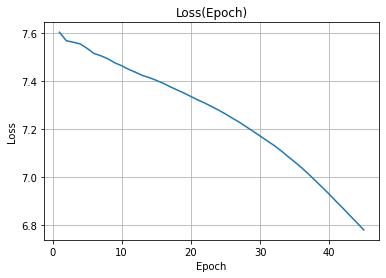

In [4]:
# Build optuna objective function.
import optuna
import sklearn 

def objective(trial):
    # Data loading
    y_max_u = pd.read_csv('..\data\ground_truth\\res_bus_vm_pu_max_focused_constr.csv')
    exogenous_data = pd.read_csv('..\data\ground_truth\\exogenous_data_vm_pu_max_focused.csv').drop(columns=['date'])
    X_max_u_train, X_max_u_test, y_max_u_train, y_max_u_test, scaler = utils.split_and_suffle(exogenous_data, y_max_u, scaling=True)
    data = {'X_train':X_max_u_train.astype(float),
            'X_test': X_max_u_test.astype(float),
            'y_train':y_max_u_train.astype(float),
            'y_test': y_max_u_test.astype(float)
        }
    # Dataset object creation
    _dataset = myai.ThesisDataset(data)
    hyper_params = {
        'input_size': _dataset.X.shape[1],
        'hidden_size': trial.suggest_int('hidden_size', 1, 100),
        'output_size': _dataset.y.shape[1],
        'n_layers': trial.suggest_int('n_layers', 1, 3),
        'dropout': trial.suggest_float('dropout', 0.0, 0.5),
        'activation': trial.suggest_categorical('activation', ['relu', 'tanh', 'sigmoid']),
        'optimizer': trial.suggest_categorical('optimizer', ['adam', 'sgd']),
        'lr': trial.suggest_float('lr', 1e-5, 1e-1, log=True),
        'epochs': trial.suggest_int('epochs', 1, 100),
        'batch_size': trial.suggest_categorical('batch_size', [1, 2, 4, 8, 16, 32, 64, 128, 256, 512, 1024]),
        'classifier': False
        }
    model = myai.Context(myai.MultilayerPerceptronStrategy(hyper_params))
    model.fit(data)
    # print(model.strategy.model.eval())
    prediction = model.predict(data).detach().numpy()
    prediction = pd.DataFrame(prediction, columns=y_max_u.columns)
    # print('bus_16 prediction: ', prediction['bus_16'])
    y_max_u_train = pd.DataFrame(y_max_u_train, columns=y_max_u.columns)
    # evaluate the regression performance with my metrics
    threshold = y_max_u_train.loc[:, y_max_u_train.max(axis=0) != 0].max(axis=0).mean() * 0.1 
    # print('threshold: ', threshold)
    metric = metrics.Metrics()
    data['y_test'] = pd.DataFrame(data['y_test'], columns=y_max_u.columns)
    # evaluate the regression performance with my metrics
    return mean_squared_error(data['y_test'], prediction, squared=False)
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=num_trials)
print("Number of finished trials: ", len(study.trials))
print("Best trial:")
trial = study.best_trial
print("  Value: {}".format(trial.value))
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))
# Write the results to a csv file.
with open("./hyper_params_results/params_mlp_regressor_focused_max_u.csv", "w") as f:
    f.write("params,value\n")
    for key, value in trial.params.items():
        f.write("{},{}\n".format(key, value))
    f.write("classifier,False\n")
    f.write("value,{}\n".format(trial.value))

# Min u

## MLP: Classification Dataset

[I 2022-09-21 17:45:09,950] A new study created in memory with name: no-name-c7b6ed92-75f2-4c0a-83a7-a144684c0303
[I 2022-09-21 17:49:21,520] Trial 0 finished with value: 0.1630268586100453 and parameters: {'hidden_size': 44, 'n_layers': 2, 'dropout': 0.1785004516122662, 'activation': 'relu', 'optimizer': 'adam', 'lr': 0.013087518546606756, 'epochs': 81, 'batch_size': 256}. Best is trial 0 with value: 0.1630268586100453.
[I 2022-09-21 17:50:15,556] Trial 1 finished with value: 0.15160267154903428 and parameters: {'hidden_size': 13, 'n_layers': 1, 'dropout': 0.37347450365504353, 'activation': 'sigmoid', 'optimizer': 'sgd', 'lr': 0.0013286173519706122, 'epochs': 39, 'batch_size': 128}. Best is trial 0 with value: 0.1630268586100453.
[I 2022-09-21 17:53:05,413] Trial 2 finished with value: 0.15051677937986474 and parameters: {'hidden_size': 1, 'n_layers': 3, 'dropout': 0.23338961048462514, 'activation': 'sigmoid', 'optimizer': 'adam', 'lr': 0.053987648467195275, 'epochs': 67, 'batch_size'

Number of finished trials:  50
Best trial:
  Value: 0.20475454736989956
  Params: 
    hidden_size: 76
    n_layers: 2
    dropout: 0.07881331134802505
    activation: relu
    optimizer: adam
    lr: 0.0032979855565955056
    epochs: 20
    batch_size: 16


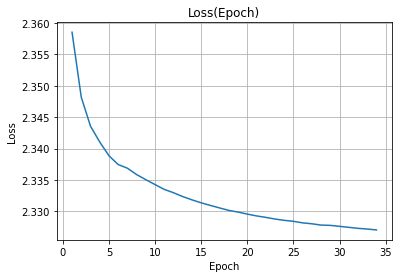

In [5]:
# Build optuna objective function.
import optuna
import sklearn 

def objective(trial):
    # Data loading
    y_min_u_bool = pd.read_csv('..\data\ground_truth\\res_bus_vm_pu_min_bool_constr.csv').drop(columns='timestamps')
    y_min_u = y_min_u_bool[utils.cols_with_positive_values(y_min_u_bool)]
    exogenous_data = pd.read_csv('..\data\processed\production\exogenous_data_extended.csv').drop(columns=['date'])
    X_min_u_bool_train, X_min_u_bool_test, y_min_u_bool_train, y_min_u_bool_test, scaler = utils.split_and_suffle(exogenous_data, y_min_u_bool, test_size=0.2, scaling=True)
    data = {'X_train':X_min_u_bool_train.astype(float),
            'X_test': X_min_u_bool_test.astype(float),
            'y_train':y_min_u_bool_train.astype(float),
            'y_test': y_min_u_bool_test.astype(float)
        }
    # Dataset object creation
    _dataset = myai.ThesisDataset(data)
    hyper_params = {
        'input_size': _dataset.X.shape[1],
        'hidden_size': trial.suggest_int('hidden_size', 1, 100),
        'output_size': _dataset.y.shape[1],
        'n_layers': trial.suggest_int('n_layers', 1, 3),
        'dropout': trial.suggest_float('dropout', 0.0, 0.5),
        'activation': trial.suggest_categorical('activation', ['relu', 'tanh', 'sigmoid']),
        'optimizer': trial.suggest_categorical('optimizer', ['adam', 'sgd']),
        'lr': trial.suggest_float('lr', 1e-5, 1e-1, log=True),
        'epochs': trial.suggest_int('epochs', 1, 100),
        'batch_size': trial.suggest_categorical('batch_size', [1, 2, 4, 8, 16, 32, 64, 128, 256, 512, 1024]),
        'classifier': True
        }
    model = myai.Context(myai.MultilayerPerceptronStrategy(hyper_params))
    model.fit(data)
    prediction = model.predict(data).detach().numpy().round().astype(bool)
    prediction = pd.DataFrame(prediction, columns=y_min_u_bool.columns)
    f1_score = sklearn.metrics.f1_score(data['y_test'], prediction, average='micro')
    return f1_score
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=num_trials)
print("Number of finished trials: ", len(study.trials))
print("Best trial:")
trial = study.best_trial
print("  Value: {}".format(trial.value))
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))
# Write the results to a csv file.
with open("./hyper_params_results/params_mlp_classifier_min_u.csv", "w") as f:
    f.write("params,value\n")
    for key, value in trial.params.items():
        f.write("{},{}\n".format(key, value))
    f.write("classifier,True\n")
    f.write("value,{}\n".format(trial.value))

## MLP: Regression Sparse Dataset

[I 2022-09-21 21:07:43,047] A new study created in memory with name: no-name-7a70ab60-bcd7-45af-bf31-a9ff649a623e
[I 2022-09-21 21:09:38,647] Trial 0 finished with value: 0.07926988190259938 and parameters: {'hidden_size': 23, 'n_layers': 1, 'dropout': 0.03333543312637938, 'activation': 'sigmoid', 'optimizer': 'sgd', 'lr': 0.028373181431507445, 'epochs': 74, 'batch_size': 128}. Best is trial 0 with value: 0.07926988190259938.
[I 2022-09-21 21:12:05,836] Trial 1 finished with value: -0.2330011690547647 and parameters: {'hidden_size': 78, 'n_layers': 1, 'dropout': 0.27880699878356485, 'activation': 'tanh', 'optimizer': 'adam', 'lr': 0.004221140805370923, 'epochs': 58, 'batch_size': 128}. Best is trial 0 with value: 0.07926988190259938.
[I 2022-09-21 21:12:30,310] Trial 2 finished with value: 0.18543026193919393 and parameters: {'hidden_size': 12, 'n_layers': 2, 'dropout': 0.1550247175340574, 'activation': 'tanh', 'optimizer': 'sgd', 'lr': 0.002012166651447783, 'epochs': 9, 'batch_size': 

Number of finished trials:  50
Best trial:
  Value: 124.92202478545231
  Params: 
    hidden_size: 57
    n_layers: 2
    dropout: 0.4962090212097388
    activation: sigmoid
    optimizer: sgd
    lr: 0.0007518807270370491
    epochs: 81
    batch_size: 32


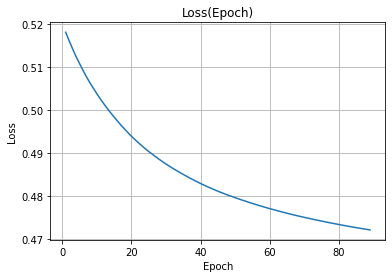

In [6]:
# Build optuna objective function.
import optuna
import sklearn 

def objective(trial):
    # Data loading
    y_min_u = pd.read_csv('..\data\ground_truth\\res_bus_vm_pu_min_constr.csv').drop(columns='timestamps')
    y_min_u = y_min_u[utils.cols_with_positive_values(y_min_u)]
    exogenous_data = pd.read_csv('..\data\processed\production\exogenous_data_extended.csv').drop(columns=['date'])
    X_min_u_train, X_min_u_test, y_min_u_train, y_min_u_test, scaler = utils.split_and_suffle(exogenous_data, y_min_u, test_size=0.2, scaling=True)
    data = {'X_train':X_min_u_train.astype(float),
            'X_test': X_min_u_test.astype(float),
            'y_train':y_min_u_train.astype(float),
            'y_test': y_min_u_test.astype(float)
        }
    # Dataset object creation
    _dataset = myai.ThesisDataset(data)
    hyper_params = {
        'input_size': _dataset.X.shape[1],
        'hidden_size': trial.suggest_int('hidden_size', 1, 100),
        'output_size': _dataset.y.shape[1],
        'n_layers': trial.suggest_int('n_layers', 1, 3),
        'dropout': trial.suggest_float('dropout', 0.0, 0.5),
        'activation': trial.suggest_categorical('activation', ['relu', 'tanh', 'sigmoid']),
        'optimizer': trial.suggest_categorical('optimizer', ['adam', 'sgd']),
        'lr': trial.suggest_float('lr', 1e-5, 1e-1, log=True),
        'epochs': trial.suggest_int('epochs', 1, 100),
        'batch_size': trial.suggest_categorical('batch_size', [1, 2, 4, 8, 16, 32, 64, 128, 256, 512, 1024]),
        'classifier': False
        }
    model = myai.Context(myai.MultilayerPerceptronStrategy(hyper_params))
    model.fit(data)
    prediction = model.predict(data).detach().numpy()
    prediction = pd.DataFrame(prediction, columns=y_min_u.columns)
    y_min_u_train = pd.DataFrame(y_min_u_train, columns=y_min_u.columns)
    # evaluate the regression performance with my metrics
    threshold = data['y_test'].loc[:, data['y_test'].max(axis=0) != 0].max(axis=0).mean() * 0.1 
    metric = metrics.Metrics()
    metric.get_prediction_scores(prediction, data['y_test'], threshold=threshold)
    return metric.hybrid_f1
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=num_trials)
print("Number of finished trials: ", len(study.trials))
print("Best trial:")
trial = study.best_trial
print("  Value: {}".format(trial.value))
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))
# Write the results to a csv file.
with open("./hyper_params_results/params_mlp_regressor_min_u.csv", "w") as f:
    f.write("params,value\n")
    for key, value in trial.params.items():
        f.write("{},{}\n".format(key, value))
    f.write("classifier,False\n")
    f.write("value,{}\n".format(trial.value))

## MLP: Regression Focused Dataset

[I 2022-09-21 23:30:04,898] A new study created in memory with name: no-name-66c023aa-a2e2-48c4-bc27-55805431f154
[I 2022-09-21 23:30:10,984] Trial 0 finished with value: 3.7347067437219583 and parameters: {'hidden_size': 21, 'n_layers': 2, 'dropout': 0.18464064376938588, 'activation': 'relu', 'optimizer': 'sgd', 'lr': 0.012406180797599817, 'epochs': 22, 'batch_size': 4}. Best is trial 0 with value: 3.7347067437219583.
[I 2022-09-21 23:30:27,980] Trial 1 finished with value: 6.761300422321103 and parameters: {'hidden_size': 98, 'n_layers': 2, 'dropout': 0.21631433121237675, 'activation': 'tanh', 'optimizer': 'adam', 'lr': 0.00051875581554285, 'epochs': 38, 'batch_size': 1024}. Best is trial 0 with value: 3.7347067437219583.
[I 2022-09-21 23:30:34,068] Trial 2 finished with value: 0.3966298946323809 and parameters: {'hidden_size': 12, 'n_layers': 1, 'dropout': 0.4975653750724009, 'activation': 'sigmoid', 'optimizer': 'sgd', 'lr': 9.619413190335823e-05, 'epochs': 35, 'batch_size': 1}. Be

Number of finished trials:  50
Best trial:
  Value: 0.1043009418012103
  Params: 
    hidden_size: 80
    n_layers: 3
    dropout: 0.08520638219479518
    activation: relu
    optimizer: sgd
    lr: 6.0293232128668264e-05
    epochs: 42
    batch_size: 8


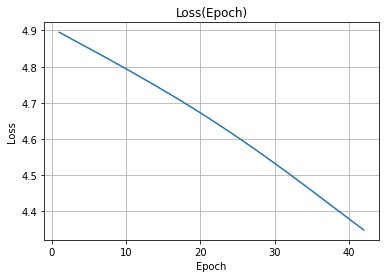

In [9]:
# Build optuna objective function.
import optuna
import sklearn 

def objective(trial):
    # Data loading
    y_min_u = pd.read_csv('..\data\ground_truth\\res_bus_vm_pu_min_focused_constr.csv')
    exogenous_data = pd.read_csv('..\data\ground_truth\\exogenous_data_vm_pu_min_focused.csv').drop(columns=['date'])
    X_min_u_train, X_min_u_test, y_min_u_train, y_min_u_test, scaler = utils.split_and_suffle(exogenous_data, y_min_u, scaling=True)
    data = {'X_train':X_min_u_train.astype(float),
            'X_test': X_min_u_test.astype(float),
            'y_train':y_min_u_train.astype(float),
            'y_test': y_min_u_test.astype(float)
        }
    # Dataset object creation
    _dataset = myai.ThesisDataset(data)
    hyper_params = {
        'input_size': _dataset.X.shape[1],
        'hidden_size': trial.suggest_int('hidden_size', 1, 100),
        'output_size': _dataset.y.shape[1],
        'n_layers': trial.suggest_int('n_layers', 1, 3),
        'dropout': trial.suggest_float('dropout', 0.0, 0.5),
        'activation': trial.suggest_categorical('activation', ['relu', 'tanh', 'sigmoid']),
        'optimizer': trial.suggest_categorical('optimizer', ['adam', 'sgd']),
        'lr': trial.suggest_float('lr', 1e-5, 1e-1, log=True),
        'epochs': trial.suggest_int('epochs', 1, 100),
        'batch_size': trial.suggest_categorical('batch_size', [1, 2, 4, 8, 16, 32, 64, 128, 256, 512, 1024]),
        'classifier': False
        }
    model = myai.Context(myai.MultilayerPerceptronStrategy(hyper_params))
    model.fit(data)
    # print(model.strategy.model.eval())
    prediction = model.predict(data).detach().numpy()
    prediction = pd.DataFrame(prediction, columns=y_min_u.columns)
    # print('bus_16 prediction: ', prediction['bus_16'])
    y_min_u_train = pd.DataFrame(y_min_u_train, columns=y_min_u.columns)
    # evaluate the regression performance with my metrics
    threshold = y_min_u_train.loc[:, y_min_u_train.max(axis=0) != 0].max(axis=0).mean() * 0.1 
    # print('threshold: ', threshold)
    metric = metrics.Metrics()
    data['y_test'] = pd.DataFrame(data['y_test'], columns=y_min_u.columns)
    # evaluate the regression performance with my metrics
    return mean_squared_error(data['y_test'], prediction, squared=False)
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=num_trials)
print("Number of finished trials: ", len(study.trials))
print("Best trial:")
trial = study.best_trial
print("  Value: {}".format(trial.value))
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))
# Write the results to a csv file.
with open("./hyper_params_results/params_mlp_regressor_focused_min_u.csv", "w") as f:
    f.write("params,value\n")
    for key, value in trial.params.items():
        f.write("{},{}\n".format(key, value))
    f.write("classifier,False\n")
    f.write("value,{}\n".format(trial.value))